## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# TODO: Import the libraries.
%pip install opencv-python --quiet
%pip install tqdm --quiet
%pip install matplotlib --quiet
%pip install torch torchvision --quiet
%pip install tensorflow --quiet

from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
error: uninstall-no-record-file

× Cannot uninstall numpy None
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==2.2.6
Note: you may need to restart the kernel to use updated packages.
OpenCV bindings requires "numpy" package.
Install it via command:
    pip install numpy


ImportError: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [ ]:
# TODO: 1. Load images from folder into a list.
import matplotlib.pyplot as plt
import numpy as np
import os
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """
    
    images = []
    labels = []
    contents = sorted(os.listdir(set_dir))
    if all(os.path.isdir(os.path.join(set_dir, c)) for c in contents):
        # If contents are directories, assume it's a train/val set
        for class_name in contents:
            class_dir = os.path.join(set_dir, class_name)
            if os.path.isdir(class_dir):
                for filename in sorted(os.listdir(class_dir)):
                    if filename.endswith('.jpg'):
                        img_path = os.path.join(class_dir, filename)
                        img = cv2.imread(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append(class_name)
    else:
        # If contents are files, assume it's a test set
        for filename in sorted(contents):
            if filename.endswith('.jpg'):
                img_path = os.path.join(set_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                
              
    return images, labels

In [ ]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []
    for img in images:
        if img.ndim != 3 or img.shape[2] not in [1, 3]:
            raise ValueError("Input images must be 3D arrays with 1 or 3 channels.")
        
        # Resize image while maintaining aspect ratio
        h, w = img.shape[:2]
        if h < w:
            new_h, new_w = target_size, int(w * target_size / h)
        else:
            new_h, new_w = int(h * target_size / w), target_size
        
        resized_img = cv2.resize(img, (new_w, new_h))
        
        # Center crop to square dimensions
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        cropped_img = resized_img[start_y:start_y + target_size, start_x:start_x + target_size]
        
        processed_images.append(cropped_img)
    
    return np.stack(processed_images)
    

: 

In [ ]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [ ]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [ ]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [ ]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

# the dataset is too large to load all at once, so will load in batches
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: List[str] = None):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        if self.labels is not None:
            return image_tensor, self.labels[idx]
        else:
            return image_tensor, -1  # Dummy label for test


tensor_train = CustomDataset(images_train, labels_train)
tensor_val = CustomDataset(images_val, labels_val)
tensor_test = CustomDataset(images_test)

# Create DataLoader for batching
batch_size = 8
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(tensor_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    print(labels)  # Labels for the batch
    break  # Just to check the first batch



torch.Size([8, 3, 224, 224])
('golden_retriever', 'parachute', 'convertible_car', 'goldfish', 'golden_retriever', 'convertible_car', 'rugby', 'goldfish')


In [ ]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
#again the dataset is too large to load all at once, so will load in batches
from torch.utils.data import DataLoader
from typing import Tuple


def compute_mean_std(loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-channel mean and standard deviation for a dataset.
    
    Args:
        loader: DataLoader for the dataset
        
    Returns:
        Tuple of (mean, std) arrays with shape (3,)
    """
    mean = torch.zeros(3)
    std = torch.zeros(3)
    count = 0
    
    for images, _ in loader:
        batch_size = images.size(0)
        count += batch_size

        mean += images.mean(dim=[0, 2, 3]) * batch_size
        std += images.std(dim=[0, 2, 3]) * batch_size

    mean /= count
    std /= count

    return mean.numpy(), std.numpy()

In [ ]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
def normalise_and_save(loader: DataLoader, mean: torch.Tensor, std: torch.Tensor, prefix: str):
    all_images = []
    all_labels = []
    
    for images, labels in loader:
        images = (images - mean[None, :, None, None]) / std[None, :, None, None]
        all_images.append(images)
        all_labels.extend(labels)

    # Stack everything into tensors
    all_images_tensor = torch.cat(all_images, dim=0)
    
    if all_labels[0] != -1:  # check if real labels
        torch.save(all_images_tensor, f'{prefix}_images.pt')
        torch.save(all_labels, f'{prefix}_labels.pt')
    else:
        torch.save(all_images_tensor, f'{prefix}_images.pt')

        
mean, std = compute_mean_std(train_loader)
mean = torch.tensor(mean, dtype=torch.float32)
std = torch.tensor(std, dtype=torch.float32)
print(f"Mean: {mean}, Std: {std}")
# Save the normalized images and labels for train, val, and test sets
normalise_and_save(train_loader, mean, std, 'train')
normalise_and_save(val_loader, mean, std, 'val')
normalise_and_save(test_loader, mean, std, 'test')

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels = list(set(labels_train + labels_val))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# 6.3 Map the labels to index.
labels_train_index = [label_to_index[label] for label in labels_train]
labels_val_index = [label_to_index[label] for label in labels_val]

# 6.4 Save the index, label_to_index, and index_to_label.
index_to_label = {idx: label for label, idx in label_to_index.items()}
def combine_all_batches(loader: DataLoader) -> torch.tensor:
    all_images = []
    all_labels = []
    for batch in loader:
        if isinstance(batch, tuple):
            images, labels = batch
            all_images.append(images)
            all_labels.extend(labels)
        else:
            all_images.append(batch)
    return torch.cat(all_images, dim=0), all_labels
train_tensor, train_labels = combine_all_batches(train_loader)
val_tensor, val_labels = combine_all_batches(val_loader)
test_tensor, _ = combine_all_batches(test_loader)

torch.save(train_tensor, 'tensor_train.pt')
torch.save(val_tensor, 'tensor_val.pt')
torch.save(test_tensor, 'tensor_test.pt')


Mean: tensor([0.4079, 0.4625, 0.4881]), Std: tensor([0.2765, 0.2557, 0.2672])


TypeError: unsupported operand type(s) for -: 'list' and 'Tensor'

In [ ]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load('tensor_train.pt')
tensor_val = torch.load('tensor_val.pt')
tensor_test = torch.load('tensor_test.pt')  


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [ ]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 
INIT_LR = 
BATCH_SIZE = 

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = 

# 2.2 Modify the output layer so that the model aligns with this project.

# 2.2 Move the model to selected device.


In [ ]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = 
criterion = 

In [ ]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []


In [ ]:
# TODO: 5. Plot the loss and accuracy curves.


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [ ]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH =
INIT_LR =
BATCH_SIZE =
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 
LOSS_RATIO = 

In [ ]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = 

In [ ]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = 

In [ ]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = 
scheduler = 

In [ ]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []


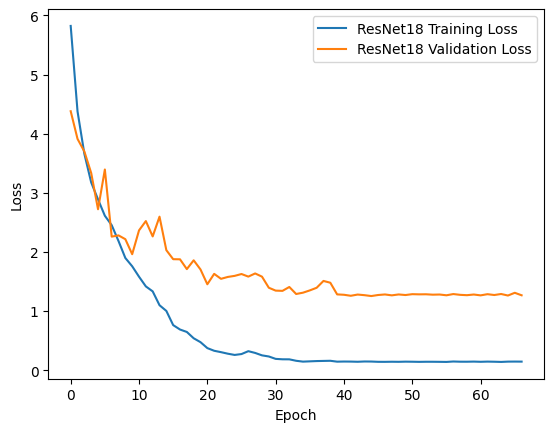

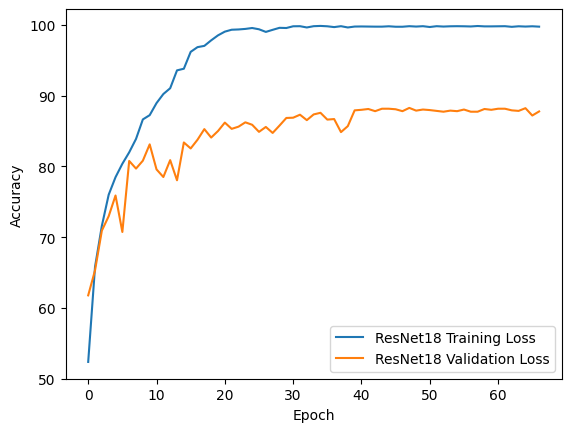

In [ ]:
# TODO: 6. Plot the loss and accuracy curves.



# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = 


In [ ]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []


In [ ]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = 
